# Case Study: Ride-Sharing Churn 

A ride-sharing company is interested in increasing ridership by reducing customer churn. In order to find what factors are the best predictors for retention, we analyzed a sample dataset of a cohort of users that had signed up for an account in January 2014. The data was pulled on July 1, 2014; a user is considered 'retained' if they were active (i.e. took a trip) in the preceding 30 days from the day the data was pulled. 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
%matplotlib inline

/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Exploratory Data Analysis

In [2]:
df = pd.read_csv('churn.csv')

In [5]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


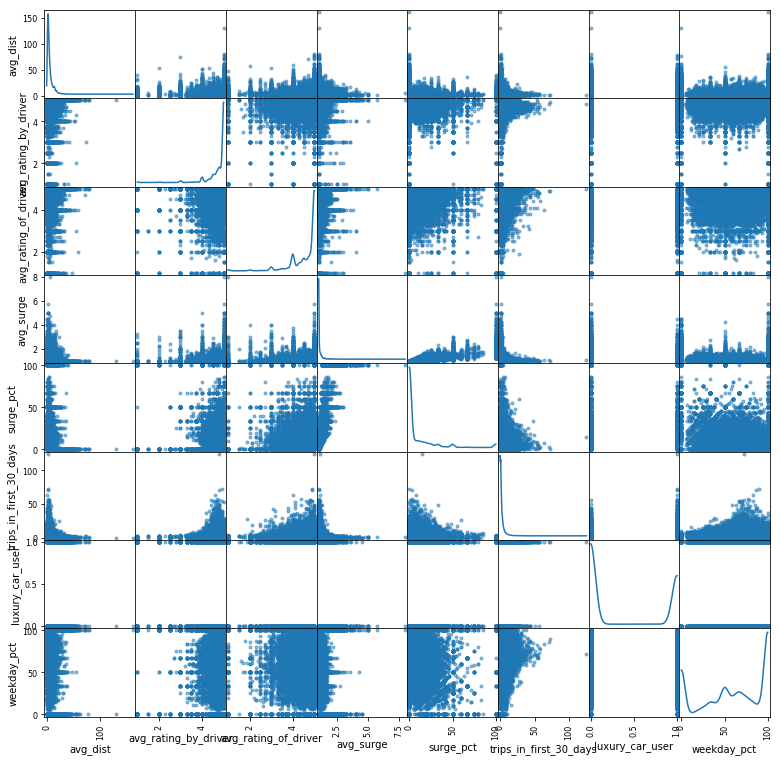

In [6]:
pd.scatter_matrix(df, diagonal='kde',figsize=(13,13))
plt.savefig('Churn_Scatter_Matrix.png',bbox_inches='tight')

In [6]:
plt.show()

# Data Cleaning & Feature Engineering

In [8]:
train = pd.read_csv('churn_train.csv',parse_dates = ['last_trip_date','signup_date'],infer_datetime_format=True)
test = pd.read_csv('churn_test.csv',parse_dates = ['last_trip_date','signup_date'],infer_datetime_format=True)
pulled_date = pd.to_datetime('2014-07-01')

train['days_since_last_trip'] =  (pulled_date - train['last_trip_date']).dt.days
test['days_since_last_trip'] = (pulled_date - test['last_trip_date']).dt.days 
train.head()
y_train_churn = (train['days_since_last_trip'].values > 30) * 1
y_test_churn = (test['days_since_last_trip'].values > 30) * 1 
#len(y_train_churn)
overall_churn_rate = float(sum(y_train_churn))/len(y_train_churn)
#overall_churn_rate = 0.6242

In [9]:
def is_weekend(data, columns):
    for col in columns:
        #weekend if day >= 5 (sat, sun)
        data[col+'_is_weekend']=data[col].dt.dayofweek >= 5
    return data

#Add columns that identify whether signup date and last trip date were on weekends
train = is_weekend(train, columns = ['last_trip_date','signup_date'])
test = is_weekend(test, columns = ['last_trip_date','signup_date'])
#train.head()


In [10]:
#Phone - dealing with null values 
train['phone'] = train['phone'].fillna('Other')
test['phone'] = test['phone'].fillna('Other')
#train.phone.unique()

#Avg rating by driver - dealing with null values 
train['avg_rating_by_driver'] = train['avg_rating_by_driver'].fillna(train['avg_rating_by_driver'].mean())
test['avg_rating_by_driver'] = test['avg_rating_by_driver'].fillna(test['avg_rating_by_driver'].mean())

#Avg rating of - dealing with null values 
train['avg_rating_of_driver']=[ by_driver if np.isnan(of_driver) else of_driver  for of_driver, by_driver in zip(train['avg_rating_of_driver'],train['avg_rating_by_driver'])]
test['avg_rating_of_driver']=[ by_driver if np.isnan(of_driver) else of_driver  for of_driver, by_driver in zip(test['avg_rating_of_driver'],test['avg_rating_by_driver'])]

#changing true, false to 1,0
train['luxury_car_user'] = train['luxury_car_user']*1
train['last_trip_date_is_weekend'] = train['last_trip_date_is_weekend']*1 
train['signup_date_is_weekend'] = train['signup_date_is_weekend']*1 
test['luxury_car_user'] = test['luxury_car_user']*1
test['last_trip_date_is_weekend'] = test['last_trip_date_is_weekend']*1 
test['signup_date_is_weekend'] = test['signup_date_is_weekend']*1 

train.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,last_trip_date_is_weekend,signup_date_is_weekend
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,0,100.0,59,1,1
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,1,0.0,156,1,1
2,21.50,4.0,4.0,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,1,100.0,41,0,0
3,9.46,5.0,5.0,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,0,100.0,172,0,0
4,13.77,5.0,5.0,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,0,100.0,49,0,0


In [11]:
#train.cities.unique()
#Changing city and phone (object types / categorical) into dummies 
def make_dummies(df, columns):
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

train_new = make_dummies(train, columns=['city','phone'])
test_new = make_dummies(test, columns=['city','phone'])
train_new.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,last_trip_date_is_weekend,signup_date_is_weekend,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,6.94,5.0,5.0,1.00,2014-05-03,2014-01-12,0.0,0,0,100.0,59,1,1,1,0,0,1,0,0
1,8.06,5.0,5.0,1.00,2014-01-26,2014-01-25,0.0,2,1,0.0,156,1,1,1,0,0,1,0,0
2,21.50,4.0,4.0,1.00,2014-05-21,2014-01-02,0.0,1,1,100.0,41,0,0,0,0,1,0,0,1
3,9.46,5.0,5.0,2.75,2014-01-10,2014-01-09,100.0,1,0,100.0,172,0,0,0,0,1,1,0,0
4,13.77,5.0,5.0,1.00,2014-05-13,2014-01-31,0.0,0,0,100.0,49,0,0,0,0,1,0,0,1


In [12]:
#Drop last trip date and signup date to prevent leakage! 
train2 = train_new.drop(['last_trip_date','signup_date','days_since_last_trip'],axis=1)
test2 = test_new.drop(['last_trip_date','signup_date','days_since_last_trip'],axis=1)
train2.info()
#training data 
X_train = train2.values
X_test = test2.values 
#X_train.shape
y_train = y_train_churn
y_test = y_test_churn


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
avg_dist                     40000 non-null float64
avg_rating_by_driver         40000 non-null float64
avg_rating_of_driver         40000 non-null float64
avg_surge                    40000 non-null float64
surge_pct                    40000 non-null float64
trips_in_first_30_days       40000 non-null int64
luxury_car_user              40000 non-null int64
weekday_pct                  40000 non-null float64
last_trip_date_is_weekend    40000 non-null int64
signup_date_is_weekend       40000 non-null int64
Astapor                      40000 non-null uint8
King's Landing               40000 non-null uint8
Winterfell                   40000 non-null uint8
Android                      40000 non-null uint8
Other                        40000 non-null uint8
iPhone                       40000 non-null uint8
dtypes: float64(6), int64(4), uint8(6)
memory usage: 3.3 MB


# Creating Models

Ran Random Forest and Gradient Boosting 

In [13]:
rf = RandomForestClassifier(oob_score=True)
rf_grid = {'max_features':['auto','sqrt','log2'],'n_estimators':[10,100,200],'random_state':[1]}
model = GridSearchCV(rf,rf_grid,n_jobs=-1)
model.fit(X_train,y_train)  


/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/ssychong/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: So

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [10, 100, 200], 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [14]:
rf_best = model.best_estimator_
rf_best_params = model.best_params_
#model.best_score_ = 0.75765
rf_best_params

{'max_features': 'auto', 'n_estimators': 200, 'random_state': 1}

In [15]:
rf_opt = RandomForestClassifier(max_features='auto',n_estimators=200, oob_score=True)
rf_opt.fit(X_train,y_train)
rf_opt.feature_importances_

array([ 0.28015127,  0.11201454,  0.07392868,  0.06405465,  0.08205416,
        0.07715025,  0.03237148,  0.12555086,  0.01761493,  0.01904453,
        0.01517442,  0.04978346,  0.01155525,  0.01902694,  0.00116342,
        0.01936115])

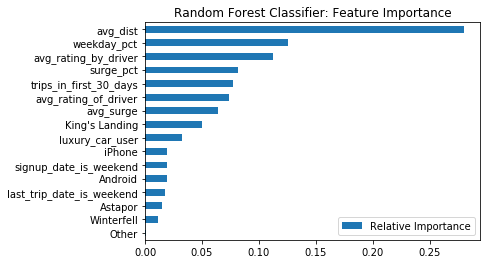

In [16]:

feat_scores = pd.DataFrame({'Relative Importance' : rf_opt.feature_importances_}, index= train2.columns)

feat_scores = feat_scores.sort_values(by='Relative Importance')
feat_scores.plot(kind='barh')
plt.title('Random Forest Classifier: Feature Importance')
plt.savefig('RF_feature.jpg',bbox_inches='tight')
plt.show()

In [17]:
gb = GradientBoostingClassifier() 
gb_grid = {'learning_rate': [.001, 0.01,0.1],
           'max_depth': [3,4,5],
           'min_samples_leaf': [15, 20, 25],
           'max_features': ['sqrt',0.3,0.4],
           'n_estimators': [10,100,200],'random_state':[1]}
gb_model = GridSearchCV(gb,gb_grid,n_jobs=-1)
gb_model.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.001, 0.01, 0.1], 'min_samples_leaf': [15, 20, 25], 'n_estimators': [10, 100, 200], 'random_state': [1], 'max_features': ['sqrt', 0.3, 0.4], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
gb_best_params = gb_model.best_params_ 
# gb_model.best_score_ = accuracy = 0.78995
gb_best_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 20,
 'n_estimators': 200,
 'random_state': 1}

In [21]:
gb_opt = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf=20, n_estimators=200,max_features='sqrt',max_depth=5)
gb_opt.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=20,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

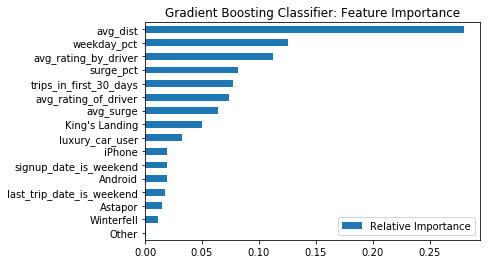

In [22]:
feat_scores_gb = pd.DataFrame({'Relative Importance' : gb_opt.feature_importances_}, index= train2.columns)

feat_scores_gb = feat_scores_gb.sort_values(by='Relative Importance')
feat_scores.plot(kind='barh')
plt.title('Gradient Boosting Classifier: Feature Importance')
plt.savefig('GB_feature.jpg',bbox_inches='tight')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
 
y_pred = gb_opt.predict(X_test) 
#accuracy_score(y_test, y_pred) = 0.78590000000000004
#f1_score(y_test, y_pred) = 0.8337861967238569
#precision_score(y_test,y_pred) = 0.8071546670674884
#recall_score(y_test,y_pred) = 0.86223506743737954

In [24]:
from sklearn.metrics import confusion_matrix
def standard_confusion_matrix(y_true, y_pred):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

standard_confusion_matrix(y_test, y_pred)


array([[5368, 1298],
       [ 860, 2474]])